In [1]:
%matplotlib inline

import numpy as np
import scipy.fft as ft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
rng = np.random.default_rng()

In [2]:
# copied from 01_fourier 4988cf4f6e81b6b9510bf55a264011c37dc71872
def ft_spectrum( signal, sample_rate, fft=None, freq=None, mask_bias=False):
    """Return a FT of $signal$, with corresponding frequencies"""
    n_samples = len(signal)
    real_signal = np.isrealobj(signal)
    
    if fft is None:
        if real_signal:
            fft = ft.rfft
            freq = ft.rfftfreq
        else:
            fft = ft.fft
            freq = ft.fftfreq

    if freq is None:
        freq = ft.fftfreq
    
    spectrum = fft(signal) / sample_rate
    freqs = freq(n_samples, 1/sample_rate)
    
    if not mask_bias:
        return spectrum, freqs
    else:
        return spectrum[1:], freqs[1:]

    
def plot_spectrum( ax, spectrum, freqs, plot_complex=False, plot_power=False, plot_amplitude=None):
    """ Plot a signal's spectrum on an Axis object"""
    plot_amplitude = plot_amplitude or (not plot_power and not plot_complex)
    alpha = 1
    
    ax.set_title("Spectrum")
    ax.set_xlabel("f (Hz)")
    ylabel = ""
    if plot_amplitude or plot_complex:
        ylabel = "Amplitude"
    if plot_power:
        if ylabel:
            ylabel += "|"
        ylabel += "Power"
    ax.set_ylabel(ylabel)

    if plot_complex:
        alpha = 0.5
        ax.plot(freqs, np.real(spectrum), '.-', label='Real', alpha=alpha)
        ax.plot(freqs, np.imag(spectrum), '.-', label='Imag', alpha=alpha)

    if plot_power:
        ax.plot(freqs, np.abs(spectrum)**2, '.-', label='Power', alpha=alpha)
    
    if plot_amplitude:
        ax.plot(freqs, np.abs(spectrum), '.-', label='Abs', alpha=alpha)

    ax.legend()

    return ax


def plot_phase( ax, spectrum, freqs, ylim_epsilon=0.5):
    ax.set_ylabel("Phase")
    ax.set_xlabel("f (Hz)")

    ax.plot(freqs, np.angle(spectrum), '.-')
    ax.set_ylim(-1*np.pi - ylim_epsilon, np.pi + ylim_epsilon)
    
    return ax


def plot_combined_spectrum(spectrum, freqs, 
                           spectrum_kwargs={}, fig=None, gs=None):
    """Plot both the frequencies and phase in one figure."""
    
    # configure plotting layout
    if fig is None:
        fig = plt.figure(figsize=(8, 16))

    if gs is None:
        gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3,1], hspace=0)

    ax1 = fig.add_subplot(gs[:-1, -1])
    ax2 = fig.add_subplot(gs[-1, -1], sharex=ax1)

    axes = np.array([ax1, ax2])
    
    # plot the spectrum 
    plot_spectrum(ax1, spectrum, freqs, **spectrum_kwargs)

    # plot the phase
    plot_phase(ax2, spectrum, freqs)

    ax1.xaxis.tick_top()
    [label.set_visible(False) for label in ax1.get_xticklabels()]
    
    return fig, axes

# Phase information in the Fourier Transform

$$
u(t) = sin(2\pi f t + \varphi_t)
$$

Define $f_\mathrm{max}$ as the frequency with the highest power in the FT (it should be close to $f$).
Then $\varphi_f$ is its associated phase.

In [3]:
sample_rate = 1/1e-4 # Hz
f = 200 # Hz
required_N_samples = sample_rate/f

signal_func = lambda phase: np.sin(phase)

print("Required signal length is: {}s".format(1/f))
print("Required number of samples: {}".format(required_N_samples))

Required signal length is: 0.005s
Required number of samples: 50.0


### $\varphi_f$ vs $f_\mathrm{max}$ for differing $\Delta f$

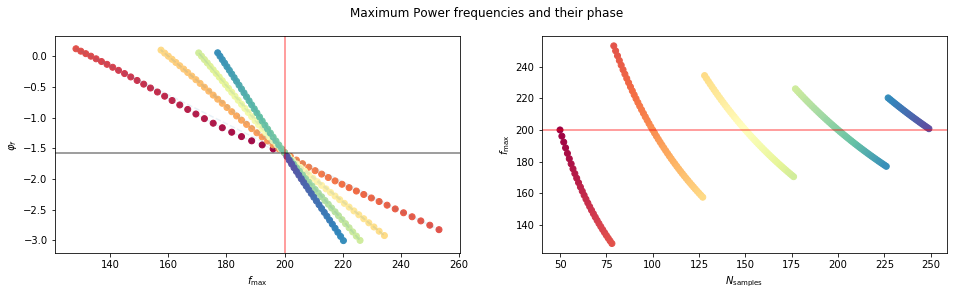

In [4]:
# \phi_f vs f_max for differing \Delta f
N_delta_f = 200


Ns_samples = required_N_samples//1 + np.arange(0, N_delta_f)
phi_f = np.empty(N_delta_f)
f_max = np.empty(N_delta_f)

# set signal_func to exp(i*phi)
if True:
    signal_func = lambda phase: np.sin(1*phase)

for i, N_sample in enumerate(Ns_samples):
    time = np.arange(N_sample) / sample_rate
    
    fft, freqs = ft_spectrum(signal_func(2*np.pi*f*time), sample_rate)
    
    fft_power = np.abs(fft)**2
    id_max = np.argmax(fft_power)
    
    phi_f[i] = np.angle(fft[id_max])
    f_max[i] = freqs[id_max]
    
    
# Maximum values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
fig.suptitle("Maximum Power frequencies and their phase")

ax1.set_xlabel('$f_\\mathrm{max}$')
ax1.set_ylabel('$\\varphi_f$')
ax1.plot(f_max, phi_f, '--', alpha=0.1)
sc = ax1.scatter(f_max, phi_f, c=Ns_samples, cmap='Spectral')
ax1.axvline(f, color='r', alpha=0.5, label="Signal frequency")
for n in [2,]:
    ax1.axhline(-np.pi/n, color='k', alpha=0.5, label='$-\\pi/{}$'.format(n))


    

ax2.set_xlabel('$N_\\mathrm{samples}$')
ax2.set_ylabel('$f_\\mathrm{max}$')
ax2.scatter(Ns_samples, f_max, c=Ns_samples, cmap='Spectral')
ax2.axhline(f, color='r', alpha=0.5, label="Signal frequency")

if False:
    ax1.set_xlim(f-5,f+5)
plt.show()

## $\varphi_f$ vs $\varphi_t$

In [5]:
sample_rate = 1/1e-4 # Hz
f = 4500# Hz
required_N_samples = sample_rate/f

signal_func = lambda phase: np.sin(phase)

print("Required signal length is: {}s".format(1/f))
print("Required number of samples: {}".format(required_N_samples))

Required signal length is: 0.00022222222222222223s
Required number of samples: 2.2222222222222223


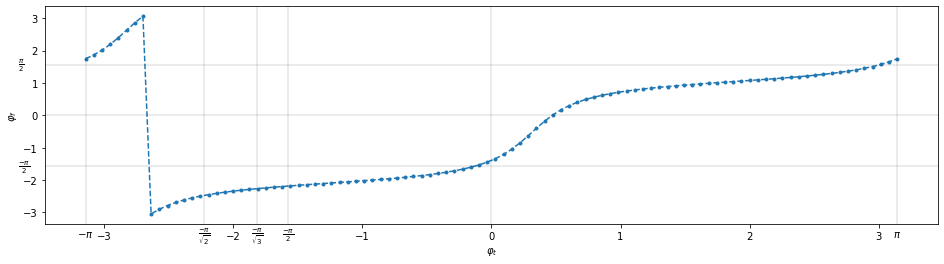

In [6]:
phase_offsets = np.linspace(-np.pi, np.pi, 100, endpoint=True) # rad

phi_f = np.empty_like(phase_offsets)

time = np.arange(required_N_samples) / sample_rate


fig, (ax1) = plt.subplots(1,1, figsize=(16,4))

for i, offset in enumerate(phase_offsets):

    fft, freqs = ft_spectrum(signal_func(2*np.pi*f*time + offset), sample_rate)       
    id_max = np.argmax(np.abs(fft)**2)
    
    phi_f[i] = np.angle(fft[id_max])    
    


ax1.set_xlabel('$\\varphi_t$')
ax1.set_ylabel('$\\varphi_f$')
ax1.plot(phase_offsets, phi_f, '.--')

# grid lines
vlines = [
    (-np.pi, r'$-\pi$'),
    (-np.pi/np.sqrt(2), r'$\frac{-\pi}{\sqrt{2}}$'),
    (-np.pi/np.sqrt(3), r'$\frac{-\pi}{\sqrt{3}}$'),
    (-np.pi/2, r'$\frac{-\pi}{2}$'),
    (np.pi, r'$\pi$'),
]

xtrans = ax1.get_xaxis_transform()
ax1.axhline(0, alpha=0.1, color='k')
for location, label in vlines:
    ax1.axvline(location, alpha=0.1, color='k')
    ax1.text(location, -0.06, label, transform=xtrans, horizontalalignment='center')

hlines = [
    (-np.pi/2, r'$\frac{-\pi}{2}$'),
    (np.pi/2, r'$\frac{\pi}{2}$'),
]

ytrans = ax1.get_yaxis_transform()
ax1.axvline(0, alpha=0.1, color='k')
for location, label in hlines:
    ax1.axhline(location, alpha=0.1, color='k')
    ax1.text(-0.03, location, label, transform=ytrans, verticalalignment='center')
    
if False:
    ax1.set_xlim(-2,-1)

plt.show()

# reconstruct phase from off-frequency ft

In [7]:
sample_rate = 1/1e-4 # Hz
f = 200 # Hz
required_N_samples = sample_rate/f

signal_func = lambda phase: np.sin(phase)

print("Required signal length is: {}s".format(1/f))
print("Required number of samples: {}".format(required_N_samples))

Required signal length is: 0.005s
Required number of samples: 50.0


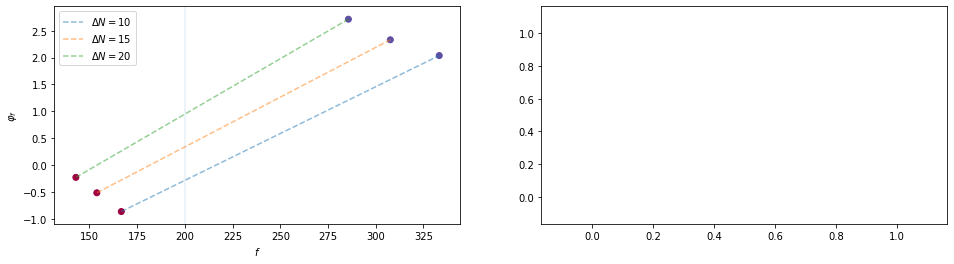

In [8]:
N_deltas = [10, 15, 20] # set !={0, required_N_sample} for imperfect FT

fig, axes = plt.subplots(1,2, figsize=(16,4))

for N_delta in N_deltas:
    time = np.arange(required_N_samples+N_delta) / sample_rate

    fft, freqs = ft_spectrum(signal_func(2*np.pi*f*time), sample_rate)

    fft_power = np.abs(fft)**2

    idx_max = np.empty(5, dtype=np.int)
    for sub in range(len(idx_max)):
        idx = np.argmax(fft_power)
        idx_max[sub] = idx
        tmp = fft_power[idx]
        fft_power[idx] = 0

    # select only the top two frequencies
    idx_top = idx_max[:2]

    axes[0].plot(freqs[idx_top], np.angle(fft[idx_top]), '--', alpha=0.5, label=r'$\Delta N = {}$'.format(N_delta))
    sc = axes[0].scatter(freqs[idx_top], np.angle(fft[idx_top]), c=idx_top, cmap='Spectral')
    
    axes[1].plot()

axes[0].set_xlabel("$f$")
axes[0].set_ylabel(r"$\varphi_f$")
axes[0].axvline(f, alpha=0.1)
axes[0].legend()
plt.show()
